In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial

In [45]:
def forward_transform_with_shadow(n, object_array, reflectivity_array, field_of_view, wavelength, samplerate):
    Object = object_array
    Reflectivity = reflectivity_array
    N = np.size(Reflectivity)
    FOV = field_of_view
    l = wavelength
    sample_rate = samplerate
    
    ## Here to the end of the cell is going through the transform and inverse by hand w/ the "shadow function"
    newx = np.arange(0,N,1)
    OneD_transform = np.empty(N,dtype=np.complex)
    OneD_forward_integrand = np.empty(N,dtype=np.complex)
    deltak = 1/FOV
    h = np.diff(Object)
    tolerance = 1e-10
    h[abs(h) < tolerance] = 0.0

    
    shadow_function = np.ones(N)
    if n > 0:
        theta = 2*np.arcsin(n*wavelength*deltak/2)
        d = h*np.tan(theta/2)
        for i in np.where(h != 0)[0]:
            dindex = int(np.floor(d[[i]]/sample_rate))
            if h[i] > 0:
                shadow_function[max(0,i-dindex-1):i+1] = 0.0
            if h[i] < 0:
                shadow_function[i:min(N,i-dindex)] = 0.0
    OneD_forward_integrand = Reflectivity*np.exp(n*(-1j)*newx*2*np.pi/N)*shadow_function
    OneD_transform = sum(OneD_forward_integrand)

    
    return OneD_transform

p = Pool()

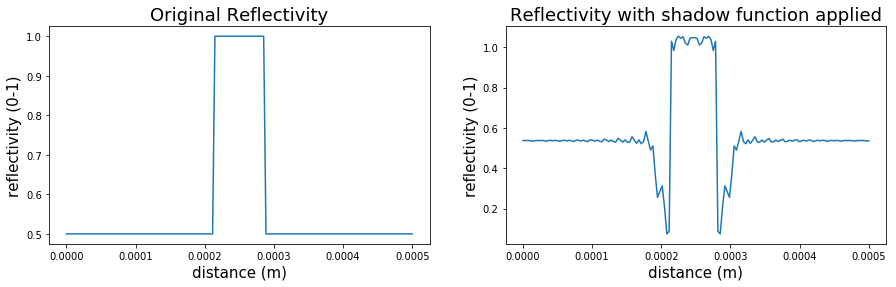

In [44]:
## setting up the range and the field of view (FOV)
N = 150
FOV = 5e-4
x = np.linspace(0,FOV,N)
sample_rate = x[2] - x[1]
l = 532e-9

## Setting up the reflectivity as a function of x. This is what we'll be taking the transform of.
Reflectivity = np.ones(N)/2
Reflectivity[int(np.floor(3*N/7)):int(np.ceil(4*N/7))] = 1
Object = Reflectivity*FOV

## Mapping transform function to a simple array for optimization purposes
IPSII = np.asarray(p.map(partial(forward_transform_with_shadow, object_array=Object, reflectivity_array=Reflectivity, field_of_view=FOV, wavelength=l, samplerate=sample_rate),range(N)))

tolerance = 1e-10
IPSII.real[abs(IPSII.real) < tolerance] = 0.0
IPSII.imag[abs(IPSII.imag) < tolerance] = 0.0


## just plotting here on out
plt.subplots(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Original Reflectivity", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,Reflectivity)

plt.subplot(1,2,2)
plt.title("Reflectivity with shadow function applied", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,np.fft.ifft((IPSII)).real)
plt.show()